## Final project, Numerical Analysis 2022-2023 ##
## Author: Cristian Curaba ##
## Date: February 2023 ##
### Project description ###
In this project, we would like to compare the performance of some embarassingly simple algorithms to solve a classification problem based on the MNIST database.
The MNIST database is based on small grey scale image of a hand-written digit.
An example of the images we'll be working on is the following:
![mnist examples](https://m-alcu.github.io/assets/mnist.png).

Let's import the images labelled divided in data train and data test.

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


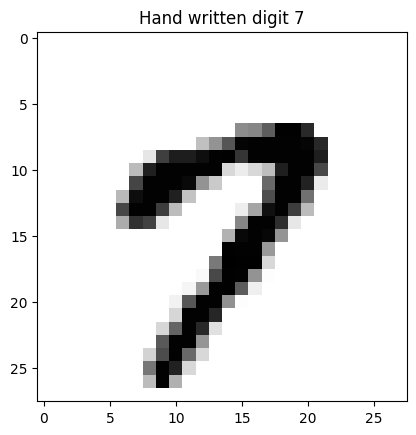

In [10]:
import matplotlib.pyplot as plt
import numpy as np

arc = np.load('mnist.npz')

x_train = arc['arr_0']
y_train = arc['arr_1']
x_test  = arc['arr_2']
y_test  = arc['arr_3']

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Show image number 15, and write in the title what digit it should correspond to
N=15
plt.imshow(x_train[N], cmap='gray_r')
_ = plt.title('Hand written digit '+str(y_train[N]))


### Naive Solution
In the following we simply build three common distances and define the function that, taking as input the number of images and the distance functions, returns the $N\times N$ matrix of distances. We plot the distance matrix (with a grey scale) with $N=100$ considering the $3$ distances.

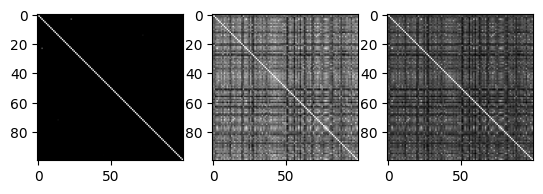

In [12]:
import numpy as np
#DISTANCES FUNCTIONS
def d_infty(a,b):
    return np.max(np.abs(b-a))
def d_one(a,b):
    return np.sum(np.abs(b-a))
def d_two(a,b):
    return np.sqrt(np.sum((b-a)*(b-a)))

x_train_reshaped=x_train.reshape(60000,784)

#DISTANCES MATRIX
def d_matrix(N=3, dist=d_infty):
    D=np.zeros(N*N,dtype=float)
    for i in range(N):
        for j in range(i,N):
            D[i*N+j]=dist(x_train_reshaped[i], x_train_reshaped[j])
            D[j*N+i]=D[i*N+j]
    return D.reshape(N,N)

Dinfty= d_matrix(N=100, dist=d_infty)
D1=d_matrix(N=100, dist=d_one)
D2=d_matrix(N=100, dist=d_two)

_,ax=plt.subplots(nrows=1, ncols=3)
ax[0].imshow(Dinfty, cmap='gray_r')
ax[1].imshow(D1,cmap='gray_r')
ax[2].imshow(D2, cmap='gray_r')


Now we build a function that, given a matrix distance (of the first $N$ test images) guess the digit, for each image, emulating the label of the nearest (with lower distance value) image and returns the efficency (the number of uncorrectly classified divided by $N$).

In [3]:
#Efficency of the distances matrix
def efficency(D):
    error_counter=0
    N=np.size(D[0,])
    for k in range(N):
        D[k,k]=np.inf
    for i in range(N):
        j=np.argmin(D[i,])
        if(y_train[j]!= y_train[i]):
            error_counter+=1
    return error_counter/N
err1=efficency(D1)
err2=efficency(D2)
errinfty=efficency(Dinfty)
print(err1, err2, errinfty)


0.17 0.17 0.58


In the following we just print the efficiency with different number of images as "training" (dimension of the distance matrix) and the three different distances.

In [4]:
#Computing matrix with columns d_one, d_two, d_infty of efficiency with
#increasing number of data
Ns=(100, 200, 400, 800)
dists=(d_one, d_two, d_infty)
M_eff=np.zeros(np.size(Ns)*np.size(dists),dtype=float)
for l in range(np.size(Ns)):
    for k in range(np.size(dists)):
        D=d_matrix(N=Ns[l], dist=dists[k])
        eff=efficency(D)
        M_eff[l*np.size(dists)+k]=eff

M_eff=np.asarray(M_eff)
M_eff=M_eff.reshape(np.size(Ns),np.size(dists))
print(M_eff)


[[0.17    0.17    0.58   ]
 [0.145   0.135   0.52   ]
 [0.15    0.135   0.4425 ]
 [0.145   0.12875 0.4    ]]


We want to build a new distance that considers a local effect, so we started building the partial derivatives of a discrete function (the image is seen as a function from a $28\times 28$ grid to real values) as following:

In [5]:
#Calculating partial derivatives of a matrix seen as discrete function
def dex(M):
    N=28
    M=M.reshape((N,N))
    dex=np.zeros(N*N, dtype=float)
    for j in range(N):
        dex[j*N]=M[j,1]-M[j,0]  #fist column partial derivative with foward difference
        dex[j*N+N-1]=M[j,N-1]-M[j,N-2] #last column partial derivative with backward difference
    for j in range(1,N-1):
        for i in range(N):
            dex[i*N+j]=(M[i,j+1]-M[i,j-1])/2 #central colums partial derivative are calculated with central difference
    return dex.reshape(784)

def dey(M):
    N=28
    M=M.reshape((N,N))
    dey=np.zeros(N*N, dtype=float)
    for j in range(N):
        dey[j]=M[1,j]-M[0,j]
        dey[N*(N-1)+j]=M[N-1,j]-M[N-2,j]
    for i in range(1,N-1):
        for j in range(N):
            dey[i*N+j]=(M[i+1,j]-M[i-1,j])/2
    return dey.reshape(784)



Below we build the $H_1$ distance and print the efficiency with different sizes.

In [6]:
#Integral of discrete function is just the sum of his values on all domain
def integrale(f):
    return f.sum()

#function for H1 distance
def d_H1(f1,f2):
    a=f1/integrale(f1)
    b=f2/integrale(f2)
    DX=dex(a-b)
    DY=dey(a-b)
    return np.sqrt(integrale(np.multiply(DX,DX) + np.multiply(DY,DY) + np.multiply(a-b,a-b)))



In [ ]:
#printing efficency on different sizes needs lot of time
for i in range(np.size(Ns)):
   DH1=d_matrix(N=Ns[i], dist=d_H1)
   print(efficency(DH1))
#15m 40s

In the next chunck we just optimize a bit what we have done before by pre computing the normalizzazion of the images and setting them as tuple.

In [7]:
#Creating vectors of normalized images.
normalized_images=np.zeros(10000*28*28).reshape((10000, 28, 28))
for i in range(10000):
        normalized_images[i]=x_train[i]/integrale(x_train[i])

#Setting it as tuple to read faster
normalized_images=tuple(normalized_images.reshape(10000, 784))

#Function for H1 distance taking as input the normalized images and avoiding the square root
def d_H1_opt(a,b):
    DX=dex(a-b)
    DY=dey(a-b)
    return integrale(np.multiply(DX,DX) + np.multiply(DY,DY) + np.multiply(a-b,a-b))

#DISTANCES MATRIX created using normalized images
def d_matrix_opt(N=3, dist=d_infty):
    D=np.zeros(N*N,dtype=float)
    for i in range(N):
        for j in range(i,N):
            D[i*N+j]=dist(normalized_images[i], normalized_images[j])
            D[j*N+i]=D[i*N+j]
    return D.reshape(N,N)

#printing efficency on different sizes optimized
for i in range(np.size(Ns)):
   DH1=d_matrix_opt(N=Ns[i], dist=d_H1_opt)
   print(efficency(DH1))

#3m 29sec instead of more then 15m

0.23
0.175
0.145
0.12125


### Solution with BallTree
Now we build the ball tree (which is a space partitioning data structure for organizing points in a multi-dimensional space) and then we select the nearest images as done above using the builded ball tree structure. In the next chunk we do it with `d_one`, `d_two`, `d_infty` distances (we avoided the `d_H1` distance since results in really high computational costs) and an increasing number of images (from $3200$ to $6400$ with a step of $400$). We store the efficiency (error rate on $500$ images) on a matrix named `efficiencies`.

In [8]:
import sklearn
from sklearn.neighbors import BallTree
#Given the Ball Tree return the efficiency (error rate on 500 immages)
def efficiency_BallTree(BTree):
    x_test_short=x_test[0:500]
    L=len(x_test_short)
    error_counter=0
    dist, k=BTree.query(x_test_short.reshape(500,28*28), k=1) #index of the first closest neighbor
    for i in range(L):
        if y_test[i]!= y_train[k[i]]:
            error_counter+=1
    return error_counter/L

efficiencies=np.zeros((4,8))

#Instead of using our implementation we will use the analogous metric already implemented because it's faster
dists_new=('manhattan', 'minkowski', 'chebyshev', d_H1) 
for aux2, N in enumerate(np.arange(3200, 6400, step=400)):
    for aux1, dist in enumerate(dists_new[0:3]):
        B2=BallTree(x_train_reshaped[:N], leaf_size=3 , metric= dist)
        effB2=efficiency_BallTree(B2)
        efficiencies[aux1, aux2]=effB2
        #print("{:.3f}".format(round(effB2, 3)))

We plot the results.

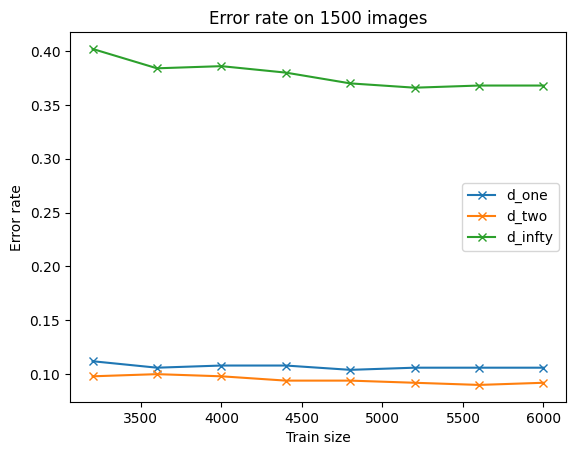

In [23]:
x1=np.arange(3200, 6400, step=400)
_=[plt.plot(x1, efficiencies[i], marker='x') for i in range(3)]
plt.title("Error rate on 1500 images")
plt.xlabel('Train size')
plt.ylabel('Error rate')
plt.gca().legend(('d_one','d_two', 'd_infty'))

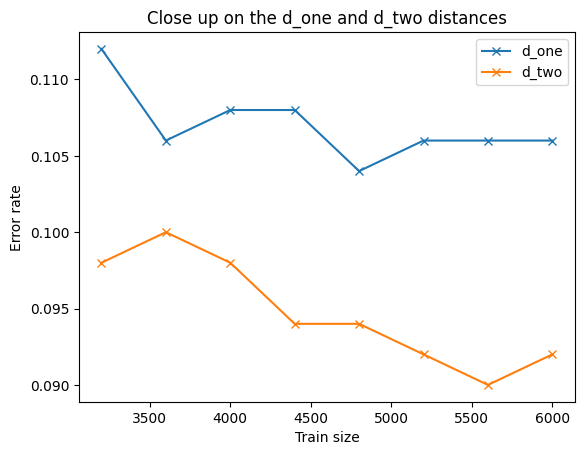

In [15]:
x1=np.arange(3200, 6400, step=400)
_=[plt.plot(x1, efficiencies[i], marker='x') for i in range(2)]
plt.title("Close up on the d_one and d_two distances")
plt.xlabel('Train size')
plt.ylabel('Error rate')
plt.gca().legend(('d_one','d_two'))

In the next chunk we use the `d_H1` distance with train size=$6000$ to compare the error rate.

In [30]:
B2=BallTree(x_train_reshaped[:6000], leaf_size=40 , metric= d_H1)
effB2=efficiency_BallTree(B2)
print("{:.3f}".format(round(effB2, 3))) #0.09 is similar to d_two error (at same train size)

0.090


Finally we try to improve the classifier rule: instead of taking just the nearest label image, we select the $k=5$ nearest elements and choose, by major voting, the digit. We then plot the results as above.

In [16]:
def findmajor(k):
    counts = np.bincount(y_train[k])
    return np.argmax(counts)

def efficiency_BallTree_voting(BTree, knear=5):
    x_test_short=x_test[0:500]
    L=len(x_test_short)
    error_counter=0
    _, k=BTree.query(x_test_short.reshape(500,28*28), k=knear) #index of the first knear closest neighbor
    for i in range(L):
        digit=findmajor(k[i])
        if y_test[i]!= digit:
            error_counter+=1
    return error_counter/L


In [17]:
efficiencies_knear=np.zeros((3,8))
#Avoiding the H1 distance
for aux2, N in enumerate(np.arange(3200, 6400, step=400)):
    for aux1, dist in enumerate(dists_new[0:2]):
        B2=BallTree(x_train_reshaped[:N], leaf_size=3 , metric= dist)
        effB2=efficiency_BallTree_voting(B2, knear=5)
        efficiencies_knear[aux1, aux2]=effB2
        #print("{:.3f}".format(round(effB2, 3)))

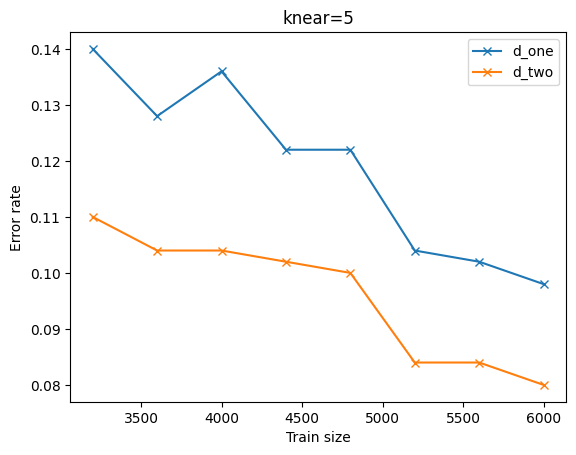

In [19]:
x1=np.arange(3200, 6400, step=400)
_=[plt.plot(x1, efficiencies_knear[i], marker='x') for i in range(2)]
plt.title("knear=5")
plt.xlabel('Train size')
plt.ylabel('Error rate')
plt.gca().legend(('d_one','d_two'))

We can see a small improvement in the larger traing sizes (`d_two` goes from $0.090$ to $0.080$ error rate with train size=$6000$).

Further improvement may be done looking at the most common errors and try to create a weighted distance ad hoc that can effectivly distinguish thoose digits.